In [16]:
# libraries used
import sys
import boto3
#import diff_predictor
#import diff_classifier.aws as aws
import pandas as pd
import seaborn as sn
import numpy as np
import matplotlib.pyplot as plt

from diff_classifier.features import *
from diff_predictor import data_process

from os import listdir, getcwd, chdir
from os.path import isfile, join
import os

from matplotlib import colors as plt_colors

from sklearn import metrics
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, scale

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from kneed import KneeLocator


from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation, DBSCAN, SpectralClustering
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture

In [2]:
if not 'workbookDir' in globals():
    workbookDir = getcwd()
print('Current Notebook Dir: ' + workbookDir)
chdir(workbookDir) # Go to current workbook Dir
chdir('..')        # Go up one
print(f'Using current directory for loading data: {getcwd()}')
workbookDir = getcwd()

Current Notebook Dir: /mnt/batch/tasks/shared/LS_root/mounts/clusters/nance8core/code/Users/nlsschim/diff_predictor/notebooks
Using current directory for loading data: /mnt/batch/tasks/shared/LS_root/mounts/clusters/nance8core/code/Users/nlsschim/diff_predictor


In [3]:
dataset_path = workbookDir + '/data/features_ecm/'
filelist = [f for f in listdir(dataset_path) if isfile(join(dataset_path, f)) and 'features_' in f]
print(len(filelist))

180


In [4]:
filelist[125]

'features_NT_brain_1_slice_2_vid_1.csv'

In [5]:
file_path = dataset_path + filelist[125]
test_df = pd.read_csv(file_path)

In [7]:
fstats_tot = data_process.generate_fullstats(dataset_path, filelist, ['ChABC'])

features_ChABC_brain_1_slice_1_vid_1.csv size: (502, 67)
features_ChABC_brain_1_slice_1_vid_2.csv size: (1734, 67)
features_ChABC_brain_1_slice_1_vid_3.csv size: (593, 67)
features_ChABC_brain_1_slice_1_vid_4.csv size: (258, 67)
features_ChABC_brain_1_slice_1_vid_5.csv size: (888, 67)
features_ChABC_brain_1_slice_2_vid_1.csv size: (1350, 67)
features_ChABC_brain_1_slice_2_vid_2.csv size: (690, 67)
features_ChABC_brain_1_slice_2_vid_3.csv size: (1257, 67)
features_ChABC_brain_1_slice_2_vid_4.csv size: (1070, 67)
features_ChABC_brain_1_slice_2_vid_5.csv size: (1097, 67)
features_ChABC_brain_1_slice_3_vid_1.csv size: (1141, 67)
features_ChABC_brain_1_slice_3_vid_2.csv size: (1307, 67)
features_ChABC_brain_1_slice_3_vid_3.csv size: (650, 67)
features_ChABC_brain_1_slice_3_vid_4.csv size: (1594, 67)
features_ChABC_brain_1_slice_3_vid_5.csv size: (1212, 67)
features_ChABC_brain_2_slice_1_vid_1.csv size: (1133, 67)
features_ChABC_brain_2_slice_1_vid_2.csv size: (2291, 67)
features_ChABC_brain

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


features_HYase_brain_1_slice_1_vid_2.csv size: (1264, 67)
features_HYase_brain_1_slice_1_vid_3.csv size: (978, 67)
features_HYase_brain_1_slice_1_vid_4.csv size: (984, 67)
features_HYase_brain_1_slice_1_vid_5.csv size: (1439, 67)
features_HYase_brain_1_slice_2_vid_1.csv size: (1233, 67)
features_HYase_brain_1_slice_2_vid_2.csv size: (1906, 67)
features_HYase_brain_1_slice_2_vid_3.csv size: (2156, 67)
features_HYase_brain_1_slice_2_vid_4.csv size: (2428, 67)
features_HYase_brain_1_slice_2_vid_5.csv size: (1733, 67)
features_HYase_brain_1_slice_3_vid_1.csv size: (1565, 67)
features_HYase_brain_1_slice_3_vid_2.csv size: (1673, 67)
features_HYase_brain_1_slice_3_vid_3.csv size: (1538, 67)
features_HYase_brain_1_slice_3_vid_4.csv size: (653, 67)
features_HYase_brain_1_slice_3_vid_5.csv size: (517, 67)
features_HYase_brain_2_slice_1_vid_1.csv size: (1761, 67)
features_HYase_brain_2_slice_1_vid_2.csv size: (1649, 67)
features_HYase_brain_2_slice_1_vid_3.csv size: (1541, 67)
features_HYase_bra

In [12]:
nt_fulldata = fstats_tot[fstats_tot['Target'] == 'ChABC']

Attempting row reduction with unsupervised learning

In [13]:
test_df = nt_fulldata

In [6]:
test_df.shape

(1173, 68)

In [7]:
# The column Deff2 currently has a super high number (~97%) of null values, so might be worth not including
# As such, it is commented out below
columns = [
    'alpha', # Fitted anomalous diffusion alpha exponenet
    'D_fit', # Fitted anomalous diffusion coefficient
    'kurtosis', # Kurtosis of track
    'asymmetry1', # Asymmetry of trajecory (0 for circular symmetric, 1 for linear)
    'asymmetry2', # Ratio of the smaller to larger principal radius of gyration
    'asymmetry3', # An asymmetric feature that accnts for non-cylindrically symmetric pt distributions
    'AR', # Aspect ratio of long and short side of trajectory's minimum bounding rectangle
    'elongation', # Est. of amount of extension of trajectory from centroid
    'boundedness', # How much a particle with Deff is restricted by a circular confinement of radius r
    'fractal_dim', # Measure of how complicated a self similar figure is
    'trappedness', # Probability that a particle with Deff is trapped in a region
    'efficiency', # Ratio of squared net displacement to the sum of squared step lengths
    'straightness', # Ratio of net displacement to the sum of squared step lengths
    'MSD_ratio', # MSD ratio of the track
   'frames', # Number of frames the track spans
   'Deff1', # Effective diffusion coefficient at 0.33 s
    #'Deff2', # Effective diffusion coefficient at 3.3 s
    'Mean alpha',
    'Mean D_fit',
    'Mean kurtosis',
    'Mean asymmetry1',
    'Mean asymmetry2',
    'Mean asymmetry3',
    'Mean AR',
    'Mean elongation',
    'Mean boundedness',
    'Mean fractal_dim',
    'Mean trappedness',
    'Mean efficiency',
    'Mean straightness',
    'Mean MSD_ratio',
    'Mean Deff1',
    #'Mean Deff2',
    'X',
    'Y'
]

ecm = test_df[columns]#.drop(['Deff2', 'Mean Deff2', 'Std Deff2'], axis=1) # Removing since 97% is null
#ecm['Treatment'] = fstats_tot['Treatment']
ecm = ecm[~ecm.isin([np.nan, np.inf, -np.inf]).any(1)] # removes rows with nan or inf points
ecm = ecm.dropna()

In [8]:
ecm.shape
test_df.shape

(1173, 68)

In [9]:
ecm[columns].isnull().sum()/len(ecm)

alpha                0.0
D_fit                0.0
kurtosis             0.0
asymmetry1           0.0
asymmetry2           0.0
asymmetry3           0.0
AR                   0.0
elongation           0.0
boundedness          0.0
fractal_dim          0.0
trappedness          0.0
efficiency           0.0
straightness         0.0
MSD_ratio            0.0
frames               0.0
Deff1                0.0
Mean alpha           0.0
Mean D_fit           0.0
Mean kurtosis        0.0
Mean asymmetry1      0.0
Mean asymmetry2      0.0
Mean asymmetry3      0.0
Mean AR              0.0
Mean elongation      0.0
Mean boundedness     0.0
Mean fractal_dim     0.0
Mean trappedness     0.0
Mean efficiency      0.0
Mean straightness    0.0
Mean MSD_ratio       0.0
Mean Deff1           0.0
X                    0.0
Y                    0.0
dtype: float64

In [10]:
features_df = ecm.drop(['X', 'Y', 'frames'], axis=1).astype(float)
#df = df.astype(float)

# Data needs to be scaled for correlation, t-SNE, and PCA analysis
ss = StandardScaler()
scaled_data = pd.DataFrame(ss.fit_transform(features_df.values), columns=features_df.columns)

scaled_data = scale(scaled_data, axis=1)
scaled_features = pd.DataFrame(scaled_data, columns = features_df.columns)
scaled_features.max()

alpha                5.001969
D_fit                4.386154
kurtosis             5.044873
asymmetry1           2.352874
asymmetry2           3.123662
asymmetry3           2.727934
AR                   4.696117
elongation           2.181253
boundedness          3.312696
fractal_dim          3.813303
trappedness          3.271138
efficiency           3.677658
straightness         3.025233
MSD_ratio            4.955359
Deff1                4.508910
Mean alpha           3.394733
Mean D_fit           3.619907
Mean kurtosis        4.882174
Mean asymmetry1      2.862484
Mean asymmetry2      3.385057
Mean asymmetry3      2.551227
Mean AR              4.056446
Mean elongation      2.124831
Mean boundedness     3.235801
Mean fractal_dim     3.657385
Mean trappedness     3.202756
Mean efficiency      3.163878
Mean straightness    2.518368
Mean MSD_ratio       4.582542
Mean Deff1           3.849973
dtype: float64

In [11]:
test_ar = np.zeros(shape=(len(range(0,5))))
print(test_ar)
test_ar[3] = 43
print(test_ar)


[0. 0. 0. 0. 0.]
[ 0.  0.  0. 43.  0.]


In [12]:
def determine_elbow(feature_df, k_range):
    """
    To do: make it possible to use multiple models
    """
    
    assert k_range[0] >= 1, "Minimum number of clusters must be >= 1"
    assert k_range[0] < k_range[1], "end range of clusters must be greater than starting number"
    
    # A list holds the SSE values for each k
    sse = []
    silhouette_coefficients = []
    print(silhouette_coefficients)
    for k in range(k_range[0], k_range[1]):
        clusterer = KMeans(n_clusters=k, init='k-means++')
        clusterer.fit(feature_df)
        sse.append(clusterer.inertia_)
        
        if k > 1: #Need to have minimum of 2 clusters for silhouette score
            silhouette_score = metrics.silhouette_score(feature_df, clusterer.labels_)
            silhouette_coefficients.append(silhouette_score)

    #Plot the SSE for each K
    plt.figure(figsize=(20,8))
    plt.style.use("fivethirtyeight")
    plt.plot(range(k_range[0], k_range[1]), sse)
    plt.xticks(range(k_range[0], k_range[1]))
    plt.xlabel("Number of Clusters")
    plt.ylabel("SSE")
    plt.show()

    plt.figure(figsize=(15,6))
    plt.style.use("fivethirtyeight")
    plt.plot(range(k_range[0], k_range[1]), silhouette_coefficients)
    plt.xticks(range(k_range[0], k_range[1]), rotation=45)
    plt.xlabel("Number of Clusters")
    plt.ylabel("Silhouette Coefficient")
    plt.show()
    
    ## Find the elbow point
    kl = KneeLocator(
        range(k_range[0], k_range[1]), sse, curve="convex", direction="decreasing"
    )

    assert kl.elbow != None, "Need to go to a higher number of clusters"
    
    print("Optimal number of clusters based on elbow method: ", kl.elbow)
    print()
    #print("original dataset length: ", len(feature_df))
    #print(f"Data reduction would be: {len(feature_df) // kl.elbow} fold")
    return len(feature_df), kl.elbow

In [15]:
def calc_max_silhouette():
    """
    
    """

In [16]:
df_len, elbow = determine_elbow(scaled_features, [20, 90])

[]


KeyboardInterrupt: 

In [ ]:
# let's take a look at what silhouette analysis looks like:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

X = scaled_features
n_clusters = 60
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(scaled_features)
cluster_labels = kmeans.labels_
score = silhouette_score(scaled_features, cluster_labels)


# Create a subplot with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)

# The 1st subplot is the silhouette plot
# The silhouette coefficient can range from -1, 1 but in this example all
# lie within [-0.1, 1]
ax1.set_xlim([-0.1, 1])
# The (n_clusters+1)*10 is for inserting blank space between silhouette
# plots of individual clusters, to demarcate them clearly.
ax1.set_ylim([0, len(scaled_features) + (n_clusters + 1) * 10])


# The silhouette_score gives the average value for all the samples.
# This gives a perspective into the density and separation of the formed
# clusters
silhouette_avg = silhouette_score(scaled_features, cluster_labels)
print("For n_clusters =", n_clusters,
    "The average silhouette_score is :", silhouette_avg)

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(scaled_features, cluster_labels)

y_lower = 10
    
for i in range(n_clusters):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = \
        sample_silhouette_values[cluster_labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.1,0, 0.2, 0.4, 0.6, 0.8, 1])

# # 2nd Plot showing the actual clusters formed
# colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
# ax2.scatter(X[:, 3], X[:, 4], marker='.', s=30, lw=0, alpha=0.7,
#                 c=colors, edgecolor='k')

# # Labeling the clusters
# centers = kmeans.cluster_centers_
# # Draw white circles at cluster centers
# ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
#             c="white", alpha=1, s=200, edgecolor='k')

# for i, c in enumerate(centers):
#     ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
#                     s=50, edgecolor='k')

# ax2.set_title("The visualization of the clustered data.")
# ax2.set_xlabel("Feature space for the 1st feature")
# ax2.set_ylabel("Feature space for the 2nd feature")

plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
           "with n_clusters = %d" % n_clusters),
           fontsize=14, fontweight='bold')

plt.show()

In [20]:
import random 
 
def colors(n): 
  ret = [] 
  r = int(random.random() * 256) 
  g = int(random.random() * 256) 
  b = int(random.random() * 256) 
  step = 256 / n 
  for i in range(n): 
    r += step 
    g += step 
    b += step 
    r = int(r) % 256 
    g = int(g) % 256 
    b = int(b) % 256 
    ret.append((r,g,b))  
  return ret 

In [13]:
def visualize_clusters(labels, df, use_centers, centers):

    #pca = PCA(2)
#  pca_centers = pca.fit_transform(cluster_centers)
    #reduced_features = pca.fit_transform(df)
    print('Using TSNE')
    tsne = TSNE(2, perplexity=30)
    #if use_centers:
        #reduced_centers = tsne.fit_transform(centers)
    reduced_features = tsne.fit_transform(df)

    #color_list = colors(20)

    u_labels = np.unique(labels)

    from scipy.spatial import ConvexHull

    def encircle(x,y, ax=None, **kw):
        if not ax: ax=plt.gca()
        p = np.c_[x,y]
        hull = ConvexHull(p)
        poly = plt.Polygon(p[hull.vertices,:], **kw)
        ax.add_patch(poly)

    plt.figure(figsize=(12,12))
    for i in u_labels:
        if i > -1:
            rand_color=np.random.rand(3,)
            plt.scatter(reduced_features[label==i, 0], reduced_features[label==i, 1], label=i, c=rand_color, s=10)
            encircle(reduced_features[label==i, 0], reduced_features[label==i, 1], ec=rand_color, fc="none")#, alpha=0.1)
            #if use_centers:
                #plt.scatter(reduced_centers[i][0], reduced_centers[i][1], c=rand_color, s=100)


    plt.legend()
    plt.show()

In [38]:
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(scaled_features)
distances, indices = nbrs.kneighbors(scaled_features)

In [35]:
np.arange(len(distances)).shape

(965,)

In [33]:
distances.shape

(965,)

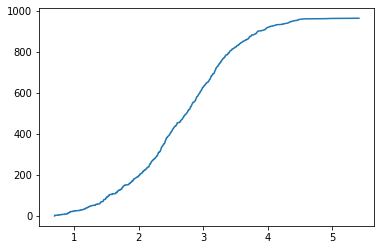

In [41]:
distances = np.sort(distances, axis=0)
x = distances[:,1]
y = np.arange(len(distances))
plt.plot(x,y)

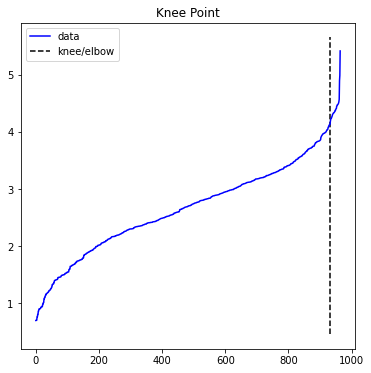

In [49]:
kl = KneeLocator(y,x, curve='convex')
kl.plot_knee()


Using TSNE


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

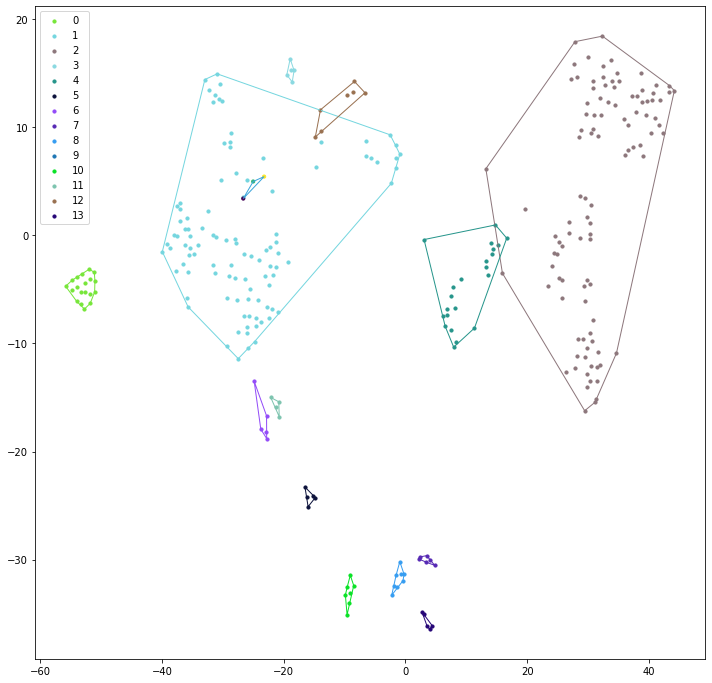

In [64]:
dbscan = DBSCAN(eps=2.8, min_samples=5)
label = dbscan.fit_predict(scaled_features)
visualize_clusters(label, scaled_features, False, None)

Using TSNE


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

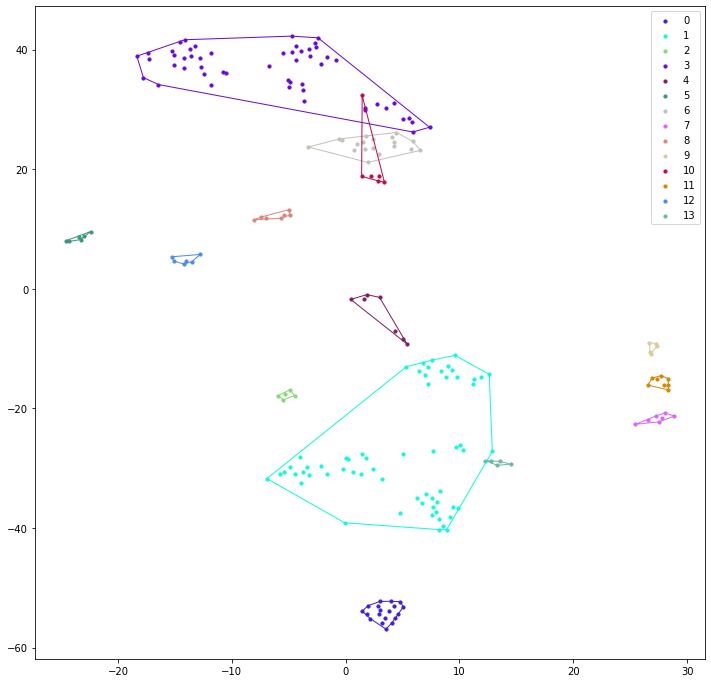

eps value:  2.6
number of clusters:  15
number of outliers:  750
number of remaining data points:  215

Using TSNE


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

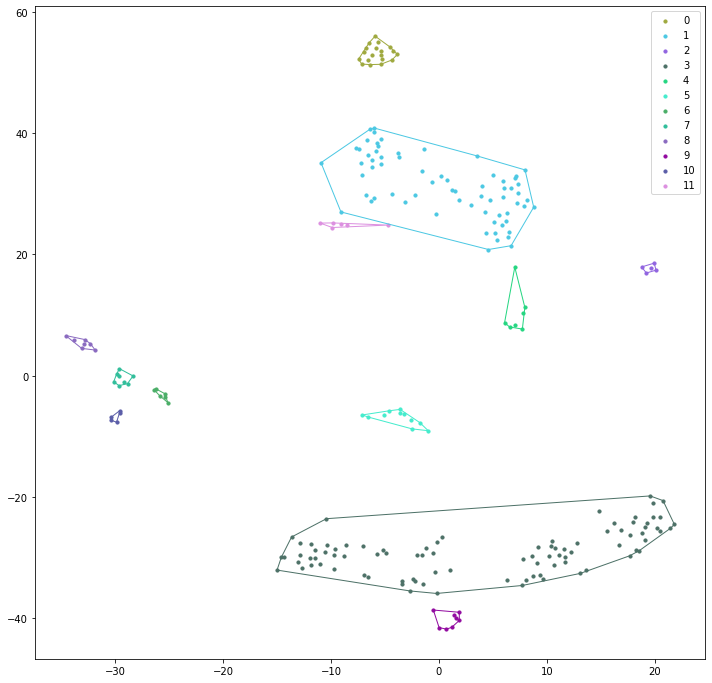

eps value:  2.7
number of clusters:  13
number of outliers:  725
number of remaining data points:  240

Using TSNE


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

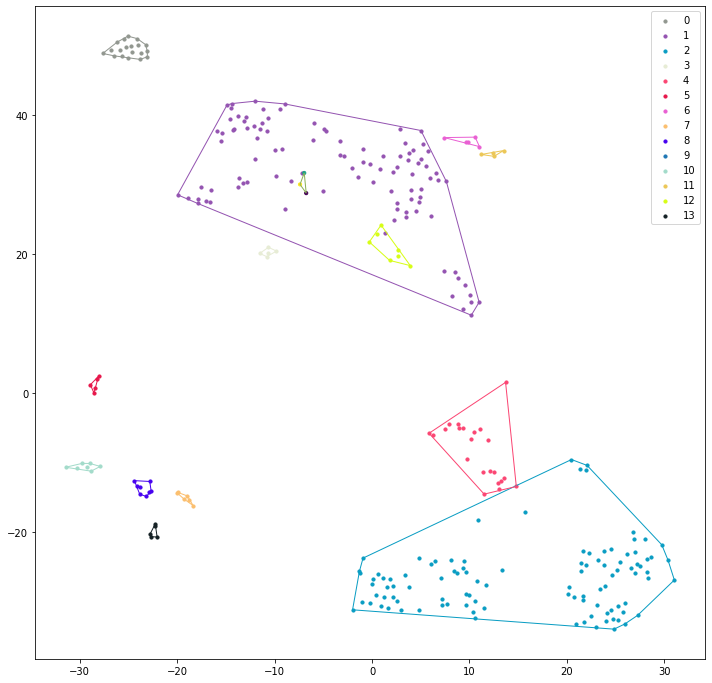

eps value:  2.8000000000000003
number of clusters:  15
number of outliers:  665
number of remaining data points:  300

Using TSNE


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

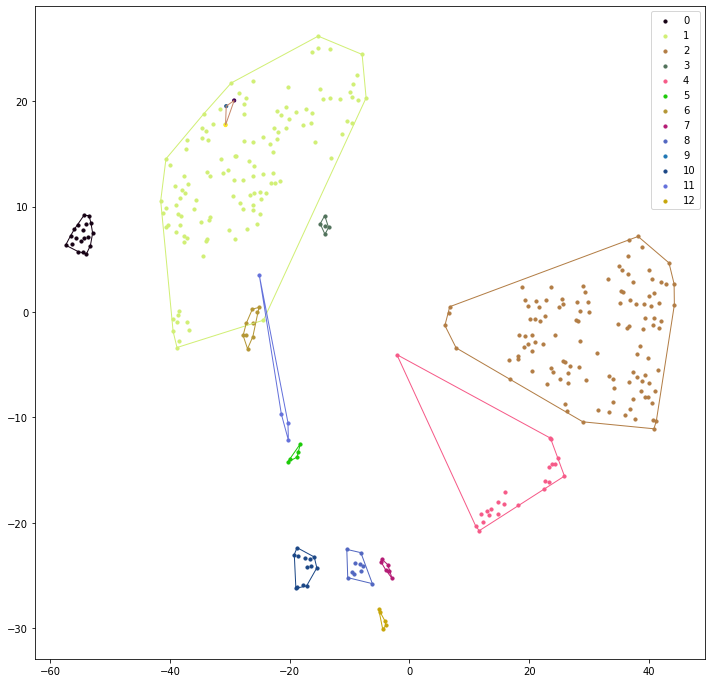

eps value:  2.9000000000000004
number of clusters:  14
number of outliers:  618
number of remaining data points:  347

Using TSNE


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

QhullError: QH6214 qhull input error: not enough points(2) to construct initial simplex (need 3)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 852699137  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _maxoutside  0


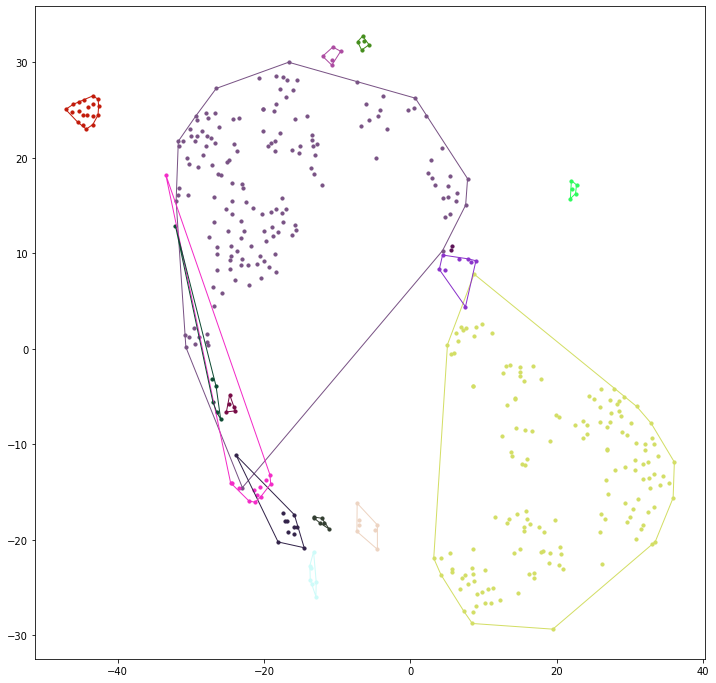

In [29]:
for i in np.arange(2.6,4,.1):
    dbscan = DBSCAN(eps=i)
    label = dbscan.fit_predict(scaled_features)
    cluster_labels = dbscan.labels_
    visualize_clusters(label, scaled_features, False, None)
    print('eps value: ', i)
    print('number of clusters: ', len(np.unique(label)))
    print('number of outliers: ', np.sum(label == -1))
    print('number of remaining data points: ', np.sum(label != -1))
    print()



In [271]:
# ChABC data

for i in np.arange(2,4,.1):
    dbscan = DBSCAN(eps=i)
    label = dbscan.fit_predict(scaled_features)
    cluster_labels = dbscan.labels_
    print('eps value: ', i)
    print('number of clusters: ', len(np.unique(label)))
    print('number of outliers: ', np.sum(label == -1))
    print('number of remaining data points: ', np.sum(label != -1))
    print()


eps value:  2.0
number of clusters:  102
number of outliers:  35349
number of remaining data points:  24160

eps value:  2.1
number of clusters:  82
number of outliers:  30571
number of remaining data points:  28938

eps value:  2.2
number of clusters:  85
number of outliers:  25768
number of remaining data points:  33741

eps value:  2.3000000000000003
number of clusters:  76
number of outliers:  21093
number of remaining data points:  38416

eps value:  2.4000000000000004
number of clusters:  47
number of outliers:  17001
number of remaining data points:  42508

eps value:  2.5000000000000004
number of clusters:  43
number of outliers:  13248
number of remaining data points:  46261

eps value:  2.6000000000000005
number of clusters:  36
number of outliers:  10128
number of remaining data points:  49381

eps value:  2.7000000000000006
number of clusters:  29
number of outliers:  7502
number of remaining data points:  52007

eps value:  2.8000000000000007
number of clusters:  16
number

In [72]:
original_row_count = 0
new_row_count = 0

for file in filelist:
    file_path = dataset_path + '/' + file
    test_df = pd.read_csv(file_path)
    
    ecm = test_df[columns]#.drop(['Deff2', 'Mean Deff2', 'Std Deff2'], axis=1) # Removing since 97% is null
    #ecm['Treatment'] = fstats_tot['Treatment']
    ecm = ecm[~ecm.isin([np.nan, np.inf, -np.inf]).any(1)] # removes rows with nan or inf points
    
    features_df = ecm.drop(['X', 'Y', 'frames'], axis=1).astype(float)
    #df = df.astype(float)

    # Data needs to be scaled for correlation, t-SNE, and PCA analysis
    ss = StandardScaler()
    scaled_data = pd.DataFrame(ss.fit_transform(features_df.values), columns=features_df.columns)

    scaled_data = scale(scaled_data, axis=1)
    scaled_features = pd.DataFrame(scaled_data, columns = features_df.columns)
    
    
    total_rows, new_rows = determine_elbow(scaled_features, [1, 100])
    original_row_count += total_rows
    new_row_count += new_rows
    
print('original number of rows: ', original_row_count)
print('reduced row count: ', new_row_count)
    


Optimal number of clusters based on elbow method:  22

Optimal number of clusters based on elbow method:  23

Optimal number of clusters based on elbow method:  21

Optimal number of clusters based on elbow method:  24

Optimal number of clusters based on elbow method:  16

Optimal number of clusters based on elbow method:  19

Optimal number of clusters based on elbow method:  21

Optimal number of clusters based on elbow method:  18

Optimal number of clusters based on elbow method:  21

Optimal number of clusters based on elbow method:  17

Optimal number of clusters based on elbow method:  18

Optimal number of clusters based on elbow method:  19

Optimal number of clusters based on elbow method:  22

Optimal number of clusters based on elbow method:  17

Optimal number of clusters based on elbow method:  17

Optimal number of clusters based on elbow method:  20

Optimal number of clusters based on elbow method:  19

Optimal number of clusters based on elbow method:  16

Optimal nu

Optimal number of clusters based on elbow method:  23

Optimal number of clusters based on elbow method:  20

Optimal number of clusters based on elbow method:  22

Optimal number of clusters based on elbow method:  19

Optimal number of clusters based on elbow method:  26

Optimal number of clusters based on elbow method:  18

Optimal number of clusters based on elbow method:  21

Optimal number of clusters based on elbow method:  17

Optimal number of clusters based on elbow method:  23

Optimal number of clusters based on elbow method:  22

Optimal number of clusters based on elbow method:  24

Optimal number of clusters based on elbow method:  23

Optimal number of clusters based on elbow method:  22

Optimal number of clusters based on elbow method:  17

Optimal number of clusters based on elbow method:  18

Optimal number of clusters based on elbow method:  19

Optimal number of clusters based on elbow method:  27

Optimal number of clusters based on elbow method:  21

Optimal nu